In [27]:
import pandas as pd
from pymongo import MongoClient
import re
from collections import defaultdict

## Individual Pages of the Documents

In [2]:
def query_tdm_or_condition(db_name, collection_name, keywords, num_results=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    regex_patterns = []
    for keyword in keywords:
        if '*' in keyword:
            pattern = re.compile(f".*{keyword.replace('*', '.*')}.*", re.IGNORECASE)
        else:
            pattern = re.compile(f"^{keyword}$", re.IGNORECASE)
        regex_patterns.append(pattern)

    cursor = collection.find({}, {"Document Name": 1, "tdm": 1})  # Fetch only required fields

    results = []
    for doc in cursor:
        tf_matrix = doc.get("tdm", [])
        term_frequencies = defaultdict(float)
        matched_terms = []

        for term_freqs in tf_matrix:
            if isinstance(term_freqs, list) and len(term_freqs) == 2:
                term, score = term_freqs
                term_frequencies[term] += score

        for term, score in term_frequencies.items():
            if any(pattern.search(term) for pattern in regex_patterns):
                matched_terms.append((term, score))

        if matched_terms:
            results.append({
                "Document Name": doc["Document Name"],
                "Total Score": sum(score for _, score in matched_terms),
                "Matched Terms": matched_terms
            })

    results.sort(key=lambda x: x["Total Score"], reverse=True)
    return results[:num_results]

In [3]:
def query_tdm_and_condition(db_name, collection_name, keywords, num_results=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    regex_patterns = {}
    for keyword in keywords:
        if '*' in keyword:
            pattern = re.compile(f".*{keyword.replace('*', '.*')}.*", re.IGNORECASE)
        else:
            pattern = re.compile(f"^{keyword}$", re.IGNORECASE)
        regex_patterns[keyword] = pattern  # Store patterns by keyword

    cursor = collection.find({}, {"Document Name": 1, "tdm": 1})  # Fetch only necessary fields

    results = []
    for doc in cursor:
        tf_matrix = doc.get("tdm", [])
        term_frequencies = defaultdict(float)
        matched_terms = []
        matched_keywords = set()  # Track which keywords have been matched

        for term_freqs in tf_matrix:
            if isinstance(term_freqs, list) and len(term_freqs) == 2:
                term, score = term_freqs
                term_frequencies[term] += score

        for keyword, pattern in regex_patterns.items():
            keyword_matched = False  # Ensure at least one term matches the keyword

            for term, score in term_frequencies.items():
                if pattern.search(term):
                    matched_terms.append((term, score))
                    matched_keywords.add(keyword)
                    keyword_matched = True
            
            # If a keyword has no match in the document, break early
            if not keyword_matched:
                break

        # Only add the document if all keywords are found
        if len(matched_keywords) == len(keywords):
            results.append({
                "Document Name": doc["Document Name"],
                "Total Score": sum(score for _, score in matched_terms),
                "Matched Terms": matched_terms
            })

    results.sort(key=lambda x: x["Total Score"], reverse=True)
    return results[:num_results]

In [4]:
def function_call_inc(keywords):
    keyword_list = []
    
    if 'OR' in keywords:
        print('OR')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('OR')]
        top_documents = query_tdm_or_condition('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    elif 'AND' in keywords:
        print('AND')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('AND')]
        print(keyword_list)
        top_documents = query_tdm_and_condition('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    else:
        keyword_list.insert(0,str(keywords))
        top_documents = query_tdm_or_condition('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    
    return top_documents

## Grouped by Documents Names

In [29]:
def query_tdm_or_condition_grouped(db_name, collection_name, keywords, num_results=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    regex_patterns = []
    for keyword in keywords:
        if '*' in keyword:
            pattern = re.compile(f".*{keyword.replace('*', '.*')}.*", re.IGNORECASE)
        else:
            pattern = re.compile(f"^{keyword}$", re.IGNORECASE)
        regex_patterns.append(pattern)

    cursor = collection.find({}, {"Document Name": 1, "tdm": 1})  # Fetch only required fields

    doc_results = defaultdict(lambda: {"Total Score": 0.0, "Matched Terms": defaultdict(float)})

    for doc in cursor:
        doc_name = doc["Document Name"]
        tf_matrix = doc.get("tdm", [])
        term_frequencies = defaultdict(float)

        for term_freqs in tf_matrix:
            if isinstance(term_freqs, list) and len(term_freqs) == 2:
                term, score = term_freqs
                term_frequencies[term] += score

        matched_terms = {
            term: score for term, score in term_frequencies.items()
            if any(pattern.search(term) for pattern in regex_patterns)
        }

        if matched_terms:
            # Aggregate scores and terms for the same document
            doc_results[doc_name]["Total Score"] += sum(matched_terms.values())
            for term, score in matched_terms.items():
                doc_results[doc_name]["Matched Terms"][term] += score

    # Convert defaultdict back to list format and sort by score
    results = [
        {
            "Document Name": doc_name,
            "Total Score": doc_data["Total Score"],
            "Matched Terms": list(doc_data["Matched Terms"].items())
        }
        for doc_name, doc_data in doc_results.items()
    ]

    results.sort(key=lambda x: x["Total Score"], reverse=True)
    return results[:num_results]


In [30]:
top_docs = query_tdm_or_condition_grouped("publications", "term_matrix_complete", ["dairy", "milk", "inheritance"])

for result in top_docs:
    print(f"Document Name: {result['Document Name']}")
    print(f"Total Frequency: {result['Total Score']}")
    
    relevant_terms = {term: freq for term, freq in result['Matched Terms'] if term in ["dairy", "milk", "inheritance"]}
    
    for term, freq in relevant_terms.items():
        print(f"  {term}: {freq}")
    print("-" * 40)

Document Name: Volatility and Risk in Irish Agriculture - REAG-0511-6268.pdf
Total Frequency: 21.408674263609957
  dairy: 11.688242013406906
  milk: 9.720432250203045
----------------------------------------
Document Name: Plant-based dairy alteRNATIVES Products Available in Supermarkets on the Island of Ireland, and Consumer Behaviours and Perceptions.pdf
Total Frequency: 18.010415435167328
  dairy: 9.58308918175162
  milk: 8.42732625341572
----------------------------------------
Document Name: A compendium of food statistics on the island of Ireland 2023.pdf
Total Frequency: 8.10806520797073
  dairy: 3.543598732924529
  milk: 4.564466475046201
----------------------------------------
Document Name: Evidence review of the food contents on carbohydrate and fats shelves of the food pyramid.pdf
Total Frequency: 7.2075033541497415
  milk: 4.972199694863798
  dairy: 2.2353036592859445
----------------------------------------
Document Name: Compendium of food statistics 2020.pdf
Total Freq

In [31]:
def query_tdm_and_condition_grouped(db_name, collection_name, keywords, num_results=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    regex_patterns = {}
    for keyword in keywords:
        if '*' in keyword:
            regex_patterns[keyword] = re.compile(f".*{keyword.replace('*', '.*')}.*", re.IGNORECASE)
        else:
            regex_patterns[keyword] = re.compile(f"^{keyword}$", re.IGNORECASE)

    cursor = collection.find({}, {"Document Name": 1, "tdm": 1})  # Fetch only required fields

    doc_results = defaultdict(lambda: {"Total Score": 0.0, "Matched Terms": defaultdict(float)})

    for doc in cursor:
        doc_name = doc["Document Name"]
        tf_matrix = doc.get("tdm", [])
        term_frequencies = defaultdict(float)

        for term_freqs in tf_matrix:
            if isinstance(term_freqs, list) and len(term_freqs) == 2:
                term, score = term_freqs
                term_frequencies[term] += score

        matched_terms = {}
        for keyword, pattern in regex_patterns.items():
            for term, score in term_frequencies.items():
                if pattern.search(term):
                    matched_terms[keyword] = (term, score)

        # **AND logic:** Only add document if it matches all keywords
        if len(matched_terms) == len(keywords):
            doc_results[doc_name]["Total Score"] += sum(score for _, score in matched_terms.values())
            for _, (term, score) in matched_terms.items():
                doc_results[doc_name]["Matched Terms"][term] += score

    # Convert defaultdict back to list format and sort by score
    results = [
        {
            "Document Name": doc_name,
            "Total Score": doc_data["Total Score"],
            "Matched Terms": list(doc_data["Matched Terms"].items())
        }
        for doc_name, doc_data in doc_results.items()
    ]

    results.sort(key=lambda x: x["Total Score"], reverse=True)
    return results[:num_results]

In [32]:
top_docs = query_tdm_and_condition_grouped("publications", "term_matrix_complete", ["dairy", "milk", "inheritance"])

for result in top_docs:
    print(f"Document Name: {result['Document Name']}")
    print(f"Total Frequency: {result['Total Score']}")
    for term, freq in result['Matched Terms']:
        print(f"  {term}: {freq}")
    print("-" * 40)

Document Name: Teagasc Food Harvest 2025 Submission.pdf
Total Frequency: 0.23534569682517933
  dairy: 0.10184070088615517
  milk: 0.05060648516282899
  inheritance: 0.08289851077619517
----------------------------------------


In [33]:
def function_call_inc_grouped(keywords):
    keyword_list = []
    
    if 'OR' in keywords:
        print('OR')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('OR')]
        top_documents = query_tdm_or_condition_grouped('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    elif 'AND' in keywords:
        print('AND')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('AND')]
        print(keyword_list)
        top_documents = query_tdm_and_condition_grouped('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    else:
        keyword_list.insert(0,str(keywords))
        top_documents = query_tdm_or_condition_grouped('publications', 'term_matrix_complete', keyword_list, num_results=1000)
    
    return top_documents

# Dairy and Carbon

In [34]:
kw = 'dairy OR dairying OR dairyman OR dairymen OR dairymaid OR dairymaids OR dairyland OR milk OR cattle'
dairy_doc = function_call_inc_grouped(kw)
print(dairy_doc)

OR
[{'Document Name': 'Volatility and Risk in Irish Agriculture - REAG-0511-6268.pdf', 'Total Score': 22.63096243581922, 'Matched Terms': [('dairy', 11.688242013406906), ('milk', 9.720432250203045), ('cattle', 0.7991142825588575), ('dairying', 0.4231738896504059)]}, {'Document Name': 'Plant-based dairy alteRNATIVES Products Available in Supermarkets on the Island of Ireland, and Consumer Behaviours and Perceptions.pdf', 'Total Score': 18.010415435167328, 'Matched Terms': [('dairy', 9.58308918175162), ('milk', 8.42732625341572)]}, {'Document Name': 'A compendium of food statistics on the island of Ireland 2023.pdf', 'Total Score': 9.818914015459972, 'Matched Terms': [('dairy', 3.543598732924529), ('milk', 4.564466475046201), ('cattle', 1.7108488074892394)]}, {'Document Name': 'Ireland â__ s National Inventory Report.pdf', 'Total Score': 9.169057911041982, 'Matched Terms': [('cattle', 6.824301941166745), ('dairy', 1.9174040195426436), ('milk', 0.4273519503325954)]}, {'Document Name': 'Co

In [35]:
kw_carbon = 'carbon OR neutrality OR emissions OR abatement'
carbon_doc = function_call_inc_grouped(kw_carbon)
print(carbon_doc)

OR
[{'Document Name': 'Ireland â__ s National Inventory Report.pdf', 'Total Score': 40.84374786525563, 'Matched Terms': [('emissions', 31.468730198620225), ('carbon', 8.909218089117637), ('abatement', 0.4657995775177507)]}, {'Document Name': 'Irelandâ__s Climate Change Assessment Volume 2..pdf', 'Total Score': 37.46615825803256, 'Matched Terms': [('neutrality', 12.496263964244447), ('carbon', 9.040082312368403), ('emissions', 14.589794614212554), ('abatement', 1.3400173672071607)]}, {'Document Name': 'Energy Demand Strategy.pdf', 'Total Score': 31.26061736088779, 'Matched Terms': [('carbon', 16.573706922678138), ('neutrality', 0.21132952991081966), ('emissions', 13.162333990328817), ('abatement', 1.3132469179700186)]}, {'Document Name': 'Smart Meter Time of Use Tariffs.pdf', 'Total Score': 31.26061736088779, 'Matched Terms': [('carbon', 16.573706922678138), ('neutrality', 0.21132952991081966), ('emissions', 13.162333990328817), ('abatement', 1.3132469179700186)]}, {'Document Name': 'Re

In [36]:
def find_matching_files(doc_list_other, doc_list_dairy):
    file_names_set_dairy = {doc['Document Name'] for doc in doc_list_dairy}
    matching_records = [other_doc for other_doc in doc_list_other if other_doc['Document Name'] in file_names_set_dairy]
    return matching_records

In [37]:
matching_records = find_matching_files(carbon_doc, dairy_doc)

print("Matching Records:", len(matching_records))
print(len(carbon_doc))
print(len(dairy_doc))

Matching Records: 322
327
416


In [38]:
dairy_carbon_doc_with_frequencies = pd.DataFrame(matching_records)
dairy_carbon_doc_with_frequencies['Query Category'] = "Dairy and Carbon"
dairy_carbon_doc_with_frequencies = dairy_carbon_doc_with_frequencies.loc[:, (dairy_carbon_doc_with_frequencies != 0).any()]
print(dairy_carbon_doc_with_frequencies)

                                         Document Name  Total Score  \
0          Ireland â__ s National Inventory Report.pdf    40.843748   
1    Irelandâ__s Climate Change Assessment Volume 2...    37.466158   
2                           Energy Demand Strategy.pdf    31.260617   
3                  Smart Meter Time of Use Tariffs.pdf    31.260617   
4            Report on the proposed Carbon Budgets.pdf    29.494518   
..                                                 ...          ...   
317  InterTradeIreland Annual Report and Accounts 2...     0.031003   
318  AgriBenchmark- benchmarking sustainable nutrie...     0.028749   
319  CROPQUEST_ New crop choices for Irish growers ...     0.027965   
320  All About Youth â__ EU Opportunities for Young...     0.025543   
321         2023 Government of Ireland Village map.pdf     0.024627   

                                         Matched Terms    Query Category  
0    [(emissions, 31.468730198620225), (carbon, 8.9...  Dairy and Carbon

In [39]:
dairy_carbon_doc_with_frequencies["Total Freq"] = dairy_carbon_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_carbon_doc_with_frequencies['Year'] = dairy_carbon_doc_with_frequencies['Document Name'].str.extract(r'(\d{4})')
print(dairy_carbon_doc_with_frequencies)

                                         Document Name  Total Score  \
0          Ireland â__ s National Inventory Report.pdf    40.843748   
1    Irelandâ__s Climate Change Assessment Volume 2...    37.466158   
2                           Energy Demand Strategy.pdf    31.260617   
3                  Smart Meter Time of Use Tariffs.pdf    31.260617   
4            Report on the proposed Carbon Budgets.pdf    29.494518   
..                                                 ...          ...   
317  InterTradeIreland Annual Report and Accounts 2...     0.031003   
318  AgriBenchmark- benchmarking sustainable nutrie...     0.028749   
319  CROPQUEST_ New crop choices for Irish growers ...     0.027965   
320  All About Youth â__ EU Opportunities for Young...     0.025543   
321         2023 Government of Ireland Village map.pdf     0.024627   

                                         Matched Terms    Query Category  \
0    [(emissions, 31.468730198620225), (carbon, 8.9...  Dairy and Carbo

# Dairy and Water

In [40]:
kw_water = 'water OR waterways OR rivers OR run-off OR nitrogen OR nitrification OR nitrous OR nitrates OR nitrifying OR algae OR algal OR alginate OR derogation OR eutrophication OR bloom OR effluent OR discharge'
water_doc = function_call_inc_grouped(kw_water)
print(water_doc)

OR
[{'Document Name': 'Final Report 4 _.pdf', 'Total Score': 32.08323439385582, 'Matched Terms': [('water', 21.547729080074276), ('discharge', 4.362332967598911), ('effluent', 2.741973188597394), ('algae', 0.11583635701353129), ('nitrogen', 1.0160774369380094), ('waterways', 0.2517308103844517), ('rivers', 1.2291185945869065), ('derogation', 0.07165641990527423), ('eutrophication', 0.487626975594902), ('nitrous', 0.2591525631621492)]}, {'Document Name': "Environmental Protection Agency â__ Ireland's Environment â__ An Integrated Assessment 2020.pdf", 'Total Score': 31.39432149099767, 'Matched Terms': [('discharge', 0.47086589764314013), ('rivers', 4.2904673036171825), ('water', 16.57446729089789), ('nitrogen', 5.264808569507251), ('nitrous', 0.5108305129993936), ('eutrophication', 1.6429295756055733), ('algal', 0.5758103994847618), ('bloom', 0.1696234043407801), ('nitrates', 0.8927242374308773), ('waterways', 0.06855351669986288), ('algae', 0.3225473673032074), ('derogation', 0.4520363

In [41]:
matching_records_water = find_matching_files(water_doc, dairy_doc)

print("Matching Records:", len(matching_records_water))
print(len(water_doc))
print(len(dairy_doc))

Matching Records: 359
368
416


In [42]:
dairy_water_doc_with_frequencies = pd.DataFrame(matching_records_water)
dairy_water_doc_with_frequencies['Query Category'] = "Dairy and Water"
dairy_water_doc_with_frequencies = dairy_water_doc_with_frequencies.loc[:, (dairy_water_doc_with_frequencies != 0).any()]
print(dairy_water_doc_with_frequencies)

                                         Document Name  Total Score  \
0                                 Final Report 4 _.pdf    32.083234   
1    Environmental Protection Agency â__ Ireland's ...    31.394321   
2    5 Identification of Potential Water-based Rece...    27.270587   
3    Compliance with the Nitrates Directive_ Implic...    23.772499   
4                         Water Quality in Ireland.pdf    23.398449   
..                                                 ...          ...   
354  The Impact of Online Trading on Local Governme...     0.034159   
355                      SBCI 2023 Mid-year Update.pdf     0.033948   
356  Strengthening Ireland's Market Focused Researc...     0.031074   
357  Review of the Irish Rope Mussel Industry (1.4M...     0.027349   
358  Ireland in South Africa and the Southern Afric...     0.024682   

                                         Matched Terms   Query Category  
0    [(water, 21.547729080074276), (discharge, 4.36...  Dairy and Water  

In [43]:
dairy_water_doc_with_frequencies["Total Freq"] = dairy_water_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_water_doc_with_frequencies['Year'] = dairy_water_doc_with_frequencies['Document Name'].str.extract(r'(\d{4})')
print(dairy_water_doc_with_frequencies)

                                         Document Name  Total Score  \
0                                 Final Report 4 _.pdf    32.083234   
1    Environmental Protection Agency â__ Ireland's ...    31.394321   
2    5 Identification of Potential Water-based Rece...    27.270587   
3    Compliance with the Nitrates Directive_ Implic...    23.772499   
4                         Water Quality in Ireland.pdf    23.398449   
..                                                 ...          ...   
354  The Impact of Online Trading on Local Governme...     0.034159   
355                      SBCI 2023 Mid-year Update.pdf     0.033948   
356  Strengthening Ireland's Market Focused Researc...     0.031074   
357  Review of the Irish Rope Mussel Industry (1.4M...     0.027349   
358  Ireland in South Africa and the Southern Afric...     0.024682   

                                         Matched Terms   Query Category  \
0    [(water, 21.547729080074276), (discharge, 4.36...  Dairy and Water 

# Dairy and Livelihood

In [44]:
kw_livelihood = 'inherit OR heritage OR inheritable OR inheritance OR inherited OR inheritor OR heritable OR succession OR rural development OR community OR social sustainability OR society OR economic viability'
livelihood_doc = function_call_inc_grouped(kw_livelihood)
print(livelihood_doc)

OR
[{'Document Name': 'Heritage Ireland 2030 Indicative Timeline.pdf', 'Total Score': 34.09333118202034, 'Matched Terms': [('heritage', 31.448898096385278), ('community', 1.5646781234580314), ('society', 0.9337716977058612), ('inherited', 0.14598326447117443)]}, {'Document Name': 'Report on Brexit and the Border.pdf', 'Total Score': 31.688898384356214, 'Matched Terms': [('community', 27.130919566458598), ('heritage', 2.1237084275987868), ('society', 2.4342703902988077)]}, {'Document Name': 'Report on Regional and Rural Transport Policy.pdf', 'Total Score': 27.46814871482838, 'Matched Terms': [('community', 24.966874829160176), ('heritage', 1.646027941480077), ('inherited', 0.19759038687980884), ('society', 0.6576555573083318)]}, {'Document Name': '2019 Annual Report.pdf', 'Total Score': 23.46562987637033, 'Matched Terms': [('heritage', 20.5967962544177), ('community', 2.3616054246328666), ('society', 0.5072281973197537)]}, {'Document Name': 'Heritage Council Annual Report 2017.pdf', 'T

In [45]:
matching_records_livelihood = find_matching_files(livelihood_doc, dairy_doc)

print("Matching Records:", len(matching_records_livelihood))
print(len(livelihood_doc))
print(len(dairy_doc))

Matching Records: 362
369
416


In [46]:
dairy_livelihood_doc_with_frequencies = pd.DataFrame(matching_records_livelihood)
dairy_livelihood_doc_with_frequencies['Query Category'] = "Dairy and Livelihood"
dairy_livelihood_doc_with_frequencies = dairy_livelihood_doc_with_frequencies.loc[:, (dairy_livelihood_doc_with_frequencies != 0).any()]
print(dairy_livelihood_doc_with_frequencies)

                                         Document Name  Total Score  \
0                  Report on Brexit and the Border.pdf    31.688898   
1    Report on Regional and Rural Transport Policy.pdf    27.468149   
2                               2019 Annual Report.pdf    23.465630   
3              Heritage Council Annual Report 2017.pdf    21.790349   
4    Our Rural Future - Rural Development Policy 20...    11.913641   
..                                                 ...          ...   
357  Optimal Design and Operation of Small-scale Wa...     0.035076   
358  Economic and Distributional Impacts of turning...     0.030673   
359  Sourcing and Assessing Agricultural Activity D...     0.029558   
360                                   PREMARA 6588.pdf     0.027627   
361                   The Business of Seafood 2020.pdf     0.024096   

                                         Matched Terms        Query Category  
0    [(community, 27.130919566458598), (heritage, 2...  Dairy and Li

In [47]:
dairy_livelihood_doc_with_frequencies["Total Freq"] = dairy_livelihood_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_livelihood_doc_with_frequencies['Year'] = dairy_livelihood_doc_with_frequencies['Document Name'].str.extract(r'(\d{4})')
print(dairy_livelihood_doc_with_frequencies)

                                         Document Name  Total Score  \
0                  Report on Brexit and the Border.pdf    31.688898   
1    Report on Regional and Rural Transport Policy.pdf    27.468149   
2                               2019 Annual Report.pdf    23.465630   
3              Heritage Council Annual Report 2017.pdf    21.790349   
4    Our Rural Future - Rural Development Policy 20...    11.913641   
..                                                 ...          ...   
357  Optimal Design and Operation of Small-scale Wa...     0.035076   
358  Economic and Distributional Impacts of turning...     0.030673   
359  Sourcing and Assessing Agricultural Activity D...     0.029558   
360                                   PREMARA 6588.pdf     0.027627   
361                   The Business of Seafood 2020.pdf     0.024096   

                                         Matched Terms        Query Category  \
0    [(community, 27.130919566458598), (heritage, 2...  Dairy and L

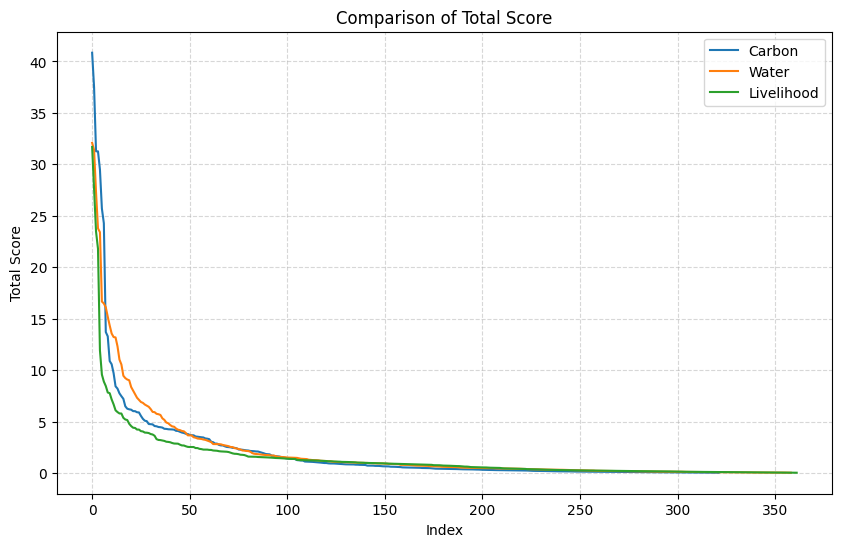

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(dairy_carbon_doc_with_frequencies['Total Freq'], label='Carbon')
plt.plot(dairy_water_doc_with_frequencies['Total Freq'], label='Water')
plt.plot(dairy_livelihood_doc_with_frequencies['Total Freq'], label='Livelihood')

plt.xlabel("Index")
plt.ylabel("Total Score")
plt.title("Comparison of Total Score")

plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [25]:
output_file = "publicationstfidf.xlsx"

with pd.ExcelWriter(output_file) as writer:
    dairy_carbon_doc_with_frequencies.to_excel(writer, sheet_name="Carbon", index=False)
    dairy_water_doc_with_frequencies.to_excel(writer, sheet_name="Water", index=False)
    dairy_livelihood_doc_with_frequencies.to_excel(writer, sheet_name="Livelihood", index=False)

print(f"DataFrames exported to {output_file}")

DataFrames exported to publicationstfidf.xlsx
